In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# If needed in a fresh Colab, you can uncomment the next line:
# !pip -q install torch torchvision

import os, random, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Reproducibility
def set_seed(seed=1337):
    random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(1337)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Build the architecture and load ImageNet-pretrained weights
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

print("Original head out_features (ImageNet):", resnet152.fc.out_features)  # 1000
total_params = sum(p.numel() for p in resnet152.parameters())
print(f"Total parameters: {total_params:,}")

Original head out_features (ImageNet): 1000
Total parameters: 60,192,808


In [ ]:
# Task (b)
# We've kep the features from the backbone which is the feature detection layers, and we've changed the head where the classification is happening
# At the head is where the vector of features is getting mapped onto specific output classes
# We're changing the output classes from a 1000 to a 100
# training a cifar model from scratch would overfit but finetuning an imagenet-pretrained model works well.
# Grab the input feature size going into the final layer
in_features = resnet152.fc.in_features

# Replace the 1000-class head with a 10-class head
resnet152.fc = nn.Linear(in_features, 10)

# Move the model (including the NEW head) to the device
resnet152 = resnet152.to(device)

print("New head out_features (CIFAR-10):", resnet152.fc.out_features)  # 10

New head out_features (CIFAR-10): 10


In [ ]:
# Part 1(c): freeze the backbone and train only the new head.

# Freeze ALL params first…
for p in resnet152.parameters():
    p.requires_grad = False

# …then unfreeze ONLY the new classification head
for p in resnet152.fc.parameters():
    p.requires_grad = True

# Loss & optimizer over JUST the head
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet152.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# Sanity check
total = sum(p.numel() for p in resnet152.parameters())
trainable = sum(p.numel() for p in resnet152.parameters() if p.requires_grad)
print(f"Total params: {total:,} | Trainable params (head only): {trainable:,}")


Total params: 58,164,298 | Trainable params (head only): 20,490


In [ ]:
# 1(d) — Data + train/validate for a few epochs and record metrics
# CIFAR-10 loaders (ImageNet-style resize & normalization for ResNet)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

root = "./data"
full_train = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_set   = datasets.CIFAR10(root, train=False, download=True, transform=val_tf)

# Split 45k/5k for train/val
val_size = 5000
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size],
                                  generator=torch.Generator().manual_seed(1337))

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- Training helpers ---
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(loader, train=False):
    resnet152.train(train)
    total_loss, total_correct, total_count = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        logits = resnet152(images)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss   += loss.item() * images.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_count  += images.size(0)

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc

# --- Train for a few epochs and record metrics ---
EPOCHS = 5  # feel free to increase to 10–20
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val = 0.0

start = time.time()
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        torch.save(resnet152.state_dict(), "resnet152_linear_probe_best.pt")

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc*100:5.2f}% | "
          f"val loss {va_loss:.4f} acc {va_acc*100:5.2f}%")

mins = (time.time() - start)/60
print(f"\nDone in {mins:.1f} min. Best val acc: {best_val*100:.2f}%")

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Epoch 01/5 | train loss 0.8416 acc 75.15% | val loss 0.6157 acc 80.48%
Epoch 02/5 | train loss 0.5787 acc 80.91% | val loss 0.5382 acc 82.48%
Epoch 03/5 | train loss 0.5289 acc 82.62% | val loss 0.5246 acc 82.58%
Epoch 04/5 | train loss 0.5040 acc 83.28% | val loss 0.5071 acc 83.32%
Epoch 05/5 | train loss 0.4880 acc 83.67% | val loss 0.5037 acc 83.02%

Done in 30.4 min. Best val acc: 83.32%


In [ ]:
# Save Task 1 (baseline) trained weights
import torch

torch.save(resnet152.state_dict(), "resnet152_task1.pth")
print("✅ Saved Task 1 weights as resnet152_task1.pth")


✅ Saved Task 1 weights as resnet152_task1.pth


In [ ]:
!cp resnet152_task1.pth /content/drive/MyDrive/


ResNet-152 has  about 60 million parameters.
CIFAR-10 has only 50,000 training images.

Training such a massive network on such a small dataset will almost surely lead to overfitting. The model memorizes training images instead of learning general features.

ResNet-152 trained on ImageNet has already learned general-purpose features: edges, textures, shapes, object parts. These features apply to most natural images (including CIFAR-10 categories like cats, cars, planes). Throwing this away to start fresh ignores valuable prior knowledge and yields worse results unless you have massive data and compute.

We prevent weight updates in the backbone (all convolutional layers) and only train the new classification head. The backbone still generates feature vectors, but its weights stay exactly as learned on ImageNet.

Even when frozen, the backbone features are good enough that the new linear head quickly reaches high accuracy on CIFAR-10. This demonstrates that features learned on ImageNet are not specific to ImageNet. Early and mid layers capture universal patterns (edges, corners, textures, color blobs, shapes). These transfer across many datasets. The only dataset-specific part is the mapping from “features” to “class labels.” That’s why retraining only the head works.

In [ ]:
#Cell 2(a) — Disable selected residual skips and prep a “modified” model (head-only training)

# Build a fresh ResNet-152 (so we don’t mutate your baseline model),
# replace the head for CIFAR-10, move to device, then freeze backbone.
import types
from copy import deepcopy
from torchvision import models
import torch.nn as nn

# 1) Fresh model (pretrained), CIFAR-10 head, on device
resnet152_mod = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
in_features = resnet152_mod.fc.in_features
resnet152_mod.fc = nn.Linear(in_features, 10)
resnet152_mod = resnet152_mod.to(device)

# 2) Freeze backbone; train only head
for p in resnet152_mod.parameters():
    p.requires_grad = False
for p in resnet152_mod.fc.parameters():
    p.requires_grad = True

# 3) Utility: list Bottleneck blocks per layer (layer1..layer4)
def get_blocks(model):
    return {
        "layer1": list(model.layer1.children()),
        "layer2": list(model.layer2.children()),
        "layer3": list(model.layer3.children()),
        "layer4": list(model.layer4.children()),
    }

# 4) Patch a Bottleneck block to REMOVE the residual addition (skip connection)
def disable_skip_for_bottleneck(block):
    # keep a reference to original forward pieces
    def no_skip_forward(self, x):
        # this mirrors torchvision.models.resnet.Bottleneck.forward, minus the skip addition
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out); out = self.relu(out)
        out = self.conv3(out); out = self.bn3(out)
        # NOTE: we intentionally do NOT compute/ add identity (no residual add)
        out = self.relu(out)
        return out

    block.forward = types.MethodType(no_skip_forward, block)

# 5) Choose which blocks to disable skip connections in (edit as you like)
#    For example: turn off skips in block 0 of layer3, and block 0 of layer4.
SKIP_OFF = {
    "layer3": [0],
    "layer4": [0],
    # You can add more, e.g., "layer3": [0, 5], "layer4": [1]
}

# 6) Apply the patch
blocks = get_blocks(resnet152_mod)
for lname, idxs in SKIP_OFF.items():
    for idx in idxs:
        disable_skip_for_bottleneck(blocks[lname][idx])

print("Disabled skip connections in:", {k: v for k, v in SKIP_OFF.items() if v})

# 7) Loss/optimizer for the modified model’s head
criterion_mod = nn.CrossEntropyLoss()
optimizer_mod = optim.AdamW(resnet152_mod.fc.parameters(), lr=1e-3, weight_decay=1e-4)

#Creates a fresh copy of ResNet-152 (pretrained) with a 10-class head and freezes the backbone (just like the baseline).
#Monkey-patches the selected Bottleneck blocks so their skip addition is removed, turning those residual blocks into plain feedforward blocks.
#Keeps training only the head so we measure the effect of changing skip connections in the (frozen) feature extractor.

Disabled skip connections in: {'layer3': [0], 'layer4': [0]}


In [ ]:
# Cell 2(b) — Re-train the modified head & compare with baseline

def run_epoch_with_model(model, loader, train, optimizer=None, criterion=None):
    model.train(train)
    total_loss, total_correct, total_count = 0.0, 0, 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss   += loss.item() * images.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_count  += images.size(0)

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc

# ---- Train the modified model’s head for a few epochs ----
EPOCHS_2 = 5   # keep same as baseline for a fair comparison
history_mod = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_mod = 0.0

start = time.time()
for epoch in range(1, EPOCHS_2 + 1):
    tr_loss, tr_acc = run_epoch_with_model(
        resnet152_mod, train_loader, train=True,
        optimizer=optimizer_mod, criterion=criterion_mod
    )
    va_loss, va_acc = run_epoch_with_model(
        resnet152_mod, val_loader, train=False,
        optimizer=None, criterion=criterion_mod
    )

    history_mod["train_loss"].append(tr_loss); history_mod["train_acc"].append(tr_acc)
    history_mod["val_loss"].append(va_loss);   history_mod["val_acc"].append(va_acc)

    if va_acc > best_val_mod:
        best_val_mod = va_acc
        torch.save(resnet152_mod.state_dict(), "resnet152_mod_linear_probe_best.pt")

    print(f"[MOD] Epoch {epoch:02d}/{EPOCHS_2} | "
          f"train loss {tr_loss:.4f} acc {tr_acc*100:5.2f}% | "
          f"val loss {va_loss:.4f} acc {va_acc*100:5.2f}%", flush=True)

mins = (time.time() - start)/60
print(f"\n[MOD] Done in {mins:.1f} min. Best val acc: {best_val_mod*100:.2f}%")

# ---- Compare with baseline, if it exists ----
# In Task 1(d) we used a dict called `history` and kept `best_val`.
# If you named them differently, adjust the keys/vars below.
if 'history' in globals():
    try:
        base_best = max(history["val_acc"]) if history["val_acc"] else float('nan')
        print(f"\nBaseline best val acc: {base_best*100:.2f}%")
    except Exception as e:
        print("\nCould not read baseline history; did you run Task 1(d) first?")
else:
    print("\nNo baseline history found; run Task 1(d) to compare.")

[MOD] Epoch 01/5 | train loss 2.0932 acc 36.40% | val loss 1.9376 acc 42.06%
[MOD] Epoch 02/5 | train loss 1.8468 acc 42.90% | val loss 1.7735 acc 43.58%
[MOD] Epoch 03/5 | train loss 1.7269 acc 44.69% | val loss 1.6745 acc 45.60%
[MOD] Epoch 04/5 | train loss 1.6598 acc 45.67% | val loss 1.6282 acc 46.70%
[MOD] Epoch 05/5 | train loss 1.6189 acc 46.73% | val loss 1.5995 acc 47.34%

[MOD] Done in 29.6 min. Best val acc: 47.34%

Baseline best val acc: 83.32%


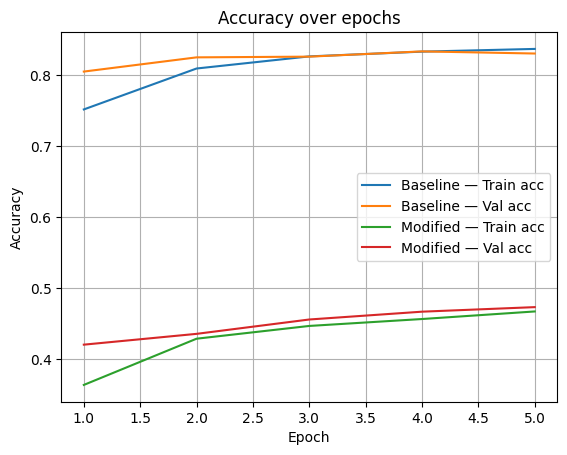

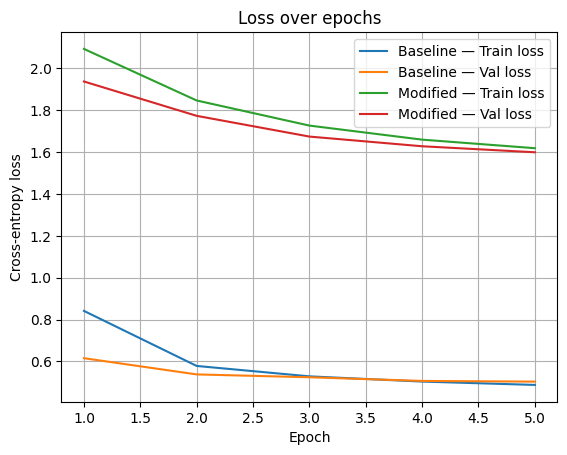

In [ ]:
import matplotlib.pyplot as plt

def safe_get(hist, key):
    return hist[key] if (hist is not None and key in hist) else None

# try to fetch baselines if present
hist_base = history if 'history' in globals() else None
hist_mod  = history_mod if 'history_mod' in globals() else None

base_epochs = range(1, len(safe_get(hist_base, "train_acc")) + 1) if hist_base else []
mod_epochs  = range(1, len(safe_get(hist_mod,  "train_acc")) + 1) if hist_mod  else []

# ----- Accuracy plot -----
plt.figure()
if hist_base:
    plt.plot(base_epochs, hist_base["train_acc"], label="Baseline — Train acc")
    plt.plot(base_epochs, hist_base["val_acc"],   label="Baseline — Val acc")
if hist_mod:
    plt.plot(mod_epochs,  hist_mod["train_acc"],  label="Modified — Train acc")
    plt.plot(mod_epochs,  hist_mod["val_acc"],    label="Modified — Val acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ----- Loss plot -----
plt.figure()
if hist_base:
    plt.plot(base_epochs, hist_base["train_loss"], label="Baseline — Train loss")
    plt.plot(base_epochs, hist_base["val_loss"],   label="Baseline — Val loss")
if hist_mod:
    plt.plot(mod_epochs,  hist_mod["train_loss"],  label="Modified — Train loss")
    plt.plot(mod_epochs,  hist_mod["val_loss"],    label="Modified — Val loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.grid(True)
plt.show()


How to read the plots

Accuracy plot: Compare the Val acc lines. If disabling skips hurt feature quality/flow, you’ll typically see the Modified — Val acc line below the baseline.

Loss plot: Higher/less stable Val loss on the modified model usually indicates optimization got harder without residual shortcuts.


In [ ]:
#Cell 3(a) — Collect features from early, middle, late layers

# Collect activations (features) from early/middle/late layers of ResNet-152
# Assumes: `resnet152`, `device`, `train_loader` or `val_loader` already exist from Task 1.

import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

resnet152.eval()  # feature extraction mode

# 1) Choose layers to tap:
#    We'll use outputs AFTER these stages:
#    - early:  after layer1
#    - middle: after layer3
#    - late:   after layer4 (right before avgpool/fc)
layers_to_hook = {
    "early": resnet152.layer1,
    "middle": resnet152.layer3,
    "late": resnet152.layer4,
}

# 2) Forward hooks to capture features (pooled to vectors)
features = {k: [] for k in layers_to_hook}
labels_all = []

def make_hook(key):
    def hook(module, inp, out):
        # out: [N, C, H, W] → global average pool → [N, C]
        x = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1)).squeeze(-1).squeeze(-1)
        features[key].append(x.detach().cpu())
    return hook

hooks = []
for k, m in layers_to_hook.items():
    hooks.append(m.register_forward_hook(make_hook(k)))

# 3) Build a SMALL, consistent subset for quick visualization (e.g., 2k images)
#    Use the validation split so it doesn't interfere with training.
N_SAMPLES = 2000  # adjust if you want more/less
subset_indices = np.arange(len(val_set))
np.random.seed(1337); np.random.shuffle(subset_indices)
subset_indices = subset_indices[:N_SAMPLES]

vis_subset = Subset(val_set, subset_indices)
vis_loader = DataLoader(vis_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# 4) Run forward passes to collect features
labels_all = []
with torch.no_grad():
    for images, labels in vis_loader:
        images = images.to(device, non_blocking=True)
        _ = resnet152(images)  # triggers hooks
        labels_all.append(labels.cpu())

# 5) Stack features and labels
for k in features:
    features[k] = torch.cat(features[k], dim=0).numpy()
labels_all = torch.cat(labels_all, dim=0).numpy()

# 6) Optional: standardize each feature matrix before DR (helps t-SNE/UMAP)
from sklearn.preprocessing import StandardScaler
scalers = {}
for k in features:
    scalers[k] = StandardScaler().fit(features[k])
    features[k] = scalers[k].transform(features[k])

print({k: f.shape for k, f in features.items()}, "labels:", labels_all.shape)

# Cleanup hooks (good practice)
for h in hooks:
    h.remove()

{'early': (2000, 256), 'middle': (2000, 1024), 'late': (2000, 2048)} labels: (2000,)


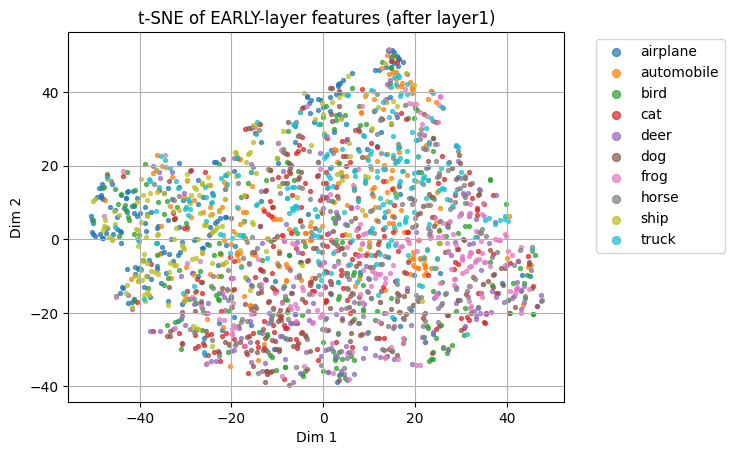

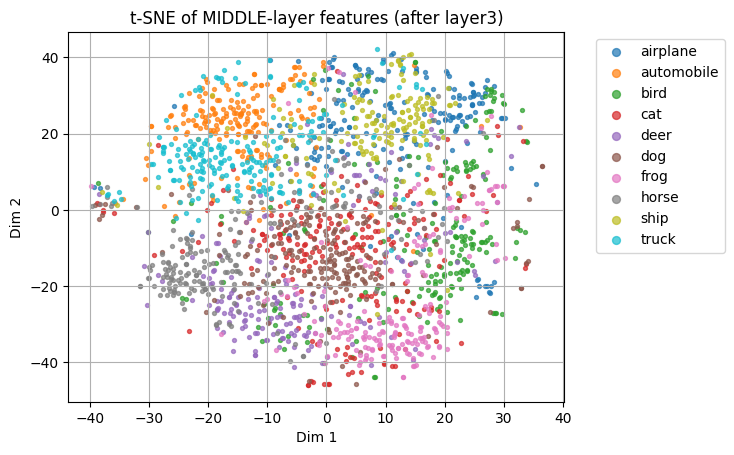

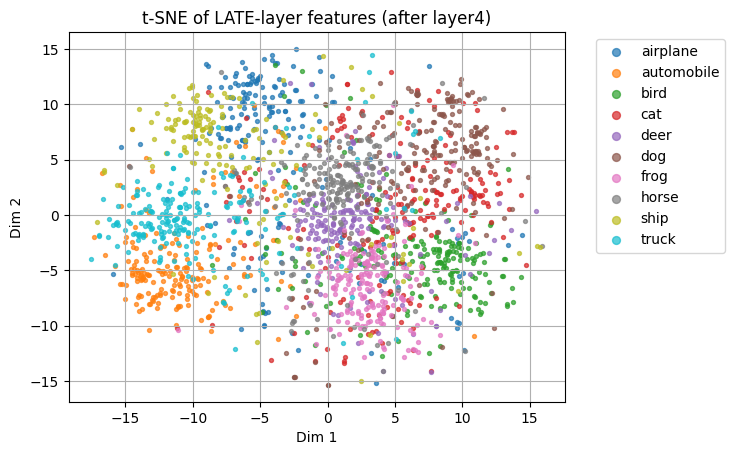

In [ ]:
#Cell 3(b) — Dimensionality reduction (t-SNE) + visualization

# Reduce to 2D with t-SNE (or UMAP) and visualize class clusters.
# Tip: t-SNE can be slow; we keep N_SAMPLES moderate. You can try UMAP for faster runs.

from sklearn.manifold import TSNE
# If you'd like UMAP instead, uncomment this line in Colab first:
# !pip -q install umap-learn
# from umap import UMAP

import matplotlib.pyplot as plt

def embed_tsne(X, seed=1337):
    # Perplexity should be < N/3. For 2000 samples, 30 is fine.
    tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=seed)
    return tsne.fit_transform(X)

# If you prefer UMAP (often faster, preserves global structure better):
# def embed_umap(X, seed=1337):
#     return UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=seed).fit_transform(X)

# Compute embeddings
Z_early  = embed_tsne(features["early"])
Z_middle = embed_tsne(features["middle"])
Z_late   = embed_tsne(features["late"])

# Class names for CIFAR-10 (for legend)
cifar10_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def scatter_2d(Z, y, title):
    plt.figure()
    for cls in range(10):
        idx = (y == cls)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=8, label=cifar10_classes[cls], alpha=0.7)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

scatter_2d(Z_early,  labels_all, "t-SNE of EARLY-layer features (after layer1)")
scatter_2d(Z_middle, labels_all, "t-SNE of MIDDLE-layer features (after layer3)")
scatter_2d(Z_late,   labels_all, "t-SNE of LATE-layer features (after layer4)")

How does class separability evolve across layers?

Early layer (after layer1):
Features are mostly low-level (edges, colors, simple textures).
On t-SNE, you’ll usually see mixed blobs with poor separability — classes overlap a lot.

Middle layer (after layer3):
Features represent parts and shapes (wheels, fur, wings).
Clusters begin to emerge; related classes start moving apart (e.g., vehicles vs. animals).

Late layer (after layer4):
Features are high-level and semantic (object-level representations).
You should observe clearer, tighter clusters and better separation among classes.

In short: separability improves as you go deeper. Early = generic visual primitives; Late = task-relevant, semantic representations.

Differences between low-level and high-level representations

Low-level (early) representations

Sensitive to local patterns: edges, corners, color blobs, fine textures.

Not invariant to pose/scale/background; cannot reliably distinguish full object categories.

Useful as universal building blocks, but not class-specific.

High-level (late) representations

Capture compositional parts and object semantics (e.g., “has wheels,” “animal face”).

More invariant to lighting, pose, small deformations, and background clutter.

Linearly separable by class much more often — which is why a simple linear head works well on top of a deep pretrained backbone.

In [ ]:
# Cell 4(a) — Dataset (CIFAR-100) + loaders (ImageNet-style preprocessing)

In [ ]:
# CIFAR-100 loaders (224x224 + ImageNet normalization so ResNet weights make sense)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf_100 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf_100 = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

root = "./data"
c100_train = datasets.CIFAR100(root, train=True,  download=True, transform=train_tf_100)
c100_test  = datasets.CIFAR100(root, train=False, download=True, transform=val_tf_100)

BATCH = 128
num_workers = 2
train_loader_100 = DataLoader(c100_train, batch_size=BATCH, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader_100   = DataLoader(c100_test,  batch_size=BATCH, shuffle=False, num_workers=num_workers, pin_memory=True)

NUM_CLASSES_100 = 100
print("CIFAR-100:", len(c100_train), "train,", len(c100_test), "test")


100%|██████████| 169M/169M [00:12<00:00, 13.3MB/s]


CIFAR-100: 50000 train, 10000 test


In [ ]:
#Cell 4(b) — Build model variants + fine-tuning controls (pretrained vs random, last block vs full)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Utilities
def build_resnet152(num_classes, init="pretrained"):
    """
    init: 'pretrained' (ImageNet) or 'random'
    """
    if init == "pretrained":
        model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
    elif init == "random":
        model = models.resnet152(weights=None)
    else:
        raise ValueError("init must be 'pretrained' or 'random'")
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model.to(device)

def set_trainable(model, mode):
    """
    mode:
      - 'head_only': freeze all except fc
      - 'last_block': unfreeze layer4 + fc
      - 'full': unfreeze entire backbone + fc
    """
    # freeze everything first
    for p in model.parameters():
        p.requires_grad = False

    if mode == "head_only":
        for p in model.fc.parameters():
            p.requires_grad = True

    elif mode == "last_block":
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True

    elif mode == "full":
        for p in model.parameters():
            p.requires_grad = True
    else:
        raise ValueError("mode must be 'head_only', 'last_block', or 'full'")

def make_optimizer(model, mode, base_lr=1e-4, head_lr=1e-3, wd=1e-4):
    """
    Use simple discriminative LRs:
      - backbone: base_lr
      - fc (head): head_lr
    """
    params = []
    if mode in ("last_block", "full"):
        back_params = []
        for name, p in model.named_parameters():
            if p.requires_grad and not name.startswith("fc."):
                back_params.append(p)
        if back_params:
            params.append({"params": back_params, "lr": base_lr, "weight_decay": wd})
    # head always has higher LR
    head_params = [p for n, p in model.named_parameters() if p.requires_grad and n.startswith("fc.")]
    if head_params:
        params.append({"params": head_params, "lr": head_lr, "weight_decay": wd})
    # If head_only, head_params is the only trainable group.
    return optim.AdamW(params)

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total += images.size(0)
    return total_loss/total, total_correct/total

def train_model(model, train_loader, val_loader, epochs, mode, log_prefix=""):
    set_trainable(model, mode)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(model, mode)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        model.train()
        total_loss, total_correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()
            total += images.size(0)

        tr_loss = total_loss/total
        tr_acc  = total_correct/total
        va_loss, va_acc = evaluate(model, val_loader, criterion)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

        print(f"{log_prefix} Epoch {epoch:02d} | "
              f"train {tr_loss:.4f}/{tr_acc*100:5.2f}% | "
              f"val {va_loss:.4f}/{va_acc*100:5.2f}%", flush=True)
    return history


In [ ]:
# ==== Part 4(c) — Only required comparisons (faster) ====

EPOCHS4 = 3    # keep low for speed; bump later if you want final numbers
USE_SUBSET = True
TRAIN_SUBSET_SIZE = 10_000
VAL_SUBSET_SIZE   = 5_000
SEED = 1337

from torch.utils.data import Subset, DataLoader
import numpy as np

rng = np.random.default_rng(SEED)

if USE_SUBSET:
    tr_idx = rng.choice(len(c100_train), size=TRAIN_SUBSET_SIZE, replace=False)
    va_idx = rng.choice(len(c100_test),  size=VAL_SUBSET_SIZE,  replace=False)

    train_loader_fast = DataLoader(Subset(c100_train, tr_idx),
                                   batch_size=BATCH, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader_fast   = DataLoader(Subset(c100_test, va_idx),
                                   batch_size=BATCH, shuffle=False, num_workers=num_workers, pin_memory=True)
else:
    train_loader_fast, val_loader_fast = train_loader_100, val_loader_100

print("Running Part 4(c) comparisons with ResNet-152…")

# 1) Pretrained + last_block
m_pt_last = build_resnet152(NUM_CLASSES_100, init="pretrained")
hist_pt_last = train_model(m_pt_last, train_loader_fast, val_loader_fast,
                           EPOCHS4, mode="last_block", log_prefix="[PT last_block]")

# 2) Pretrained + full
m_pt_full = build_resnet152(NUM_CLASSES_100, init="pretrained")
hist_pt_full = train_model(m_pt_full, train_loader_fast, val_loader_fast,
                           EPOCHS4, mode="full", log_prefix="[PT full     ]")

# Summaries
def best_val(hist):
    return max(hist["val_acc"]) if hist and hist["val_acc"] else float("nan")

print("\nBest val acc (fast run):")
print("Pretrained + last_block:", f"{best_val(hist_pt_last)*100:.2f}%")
print("Pretrained + full      :", f"{best_val(hist_pt_full)*100:.2f}%")



Running Part 4(c) comparisons with ResNet-152…
[PT last_block] Epoch 01 | train 3.2382/26.91% | val 1.9236/47.76%
[PT last_block] Epoch 02 | train 1.7017/52.69% | val 1.5945/54.88%
[PT last_block] Epoch 03 | train 1.3616/61.72% | val 1.4434/59.30%


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 80.12 MiB is free. Process 21477 has 14.66 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 112.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# === PT + full (RN152) with AMP (fp32 weights), checkpointing (layer2-4), tiny batch ===
import os, gc, torch, numpy as np
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.amp import GradScaler, autocast
from torch.utils.checkpoint import checkpoint

# allocator + perf knobs
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0) move anything lingering to CPU and delete
for name, obj in list(globals().items()):
    if hasattr(obj, "to") and callable(getattr(obj, "to")):
        try: obj.to("cpu")
        except: pass
for n in ["m_pt_last","m_pt_full","m_rand_full","m_rand_last","resnet152","resnet152_mod"]:
    if n in globals(): del globals()[n]
gc.collect();
if torch.cuda.is_available(): torch.cuda.empty_cache()

# 1) rebuild model on CPU (fp32), then move to CUDA (still fp32)
def build_resnet152_cpu(num_classes, init="pretrained"):
    weights = models.ResNet152_Weights.IMAGENET1K_V2 if init == "pretrained" else None
    m = models.resnet152(weights=weights)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

m_pt_full = build_resnet152_cpu(NUM_CLASSES_100, init="pretrained")
m_pt_full = m_pt_full.to(device)  # keep fp32 weights

# 2) gradient checkpointing on heavy layers (use_reentrant=False to avoid warning & save mem)
def ckpt_layer(layer):
    for block in layer:
        orig = block.forward
        def fwd(x, _orig=orig):
            return checkpoint(_orig, x, use_reentrant=False)
        block.forward = fwd

ckpt_layer(m_pt_full.layer2)
ckpt_layer(m_pt_full.layer3)
ckpt_layer(m_pt_full.layer4)

# full fine-tuning
for p in m_pt_full.parameters():
    p.requires_grad = True

# 3) tiny batch + reuse same subset as your last_block run if available
BATCH_FULL = 4                       # drop to 3 or 2 if you still OOM
NUM_WORKERS = 2
rng = np.random.default_rng(1337)

if 'train_loader_fast' in globals() and isinstance(train_loader_fast.dataset, Subset):
    tr_idx = train_loader_fast.dataset.indices
    va_idx = val_loader_fast.dataset.indices
else:
    TRAIN_SUBSET_SIZE = min(10_000, len(c100_train))
    VAL_SUBSET_SIZE   = min(5_000,  len(c100_test))
    tr_idx = rng.choice(len(c100_train), size=TRAIN_SUBSET_SIZE, replace=False)
    va_idx = rng.choice(len(c100_test),  size=VAL_SUBSET_SIZE,  replace=False)

train_loader_full = DataLoader(Subset(c100_train, tr_idx), batch_size=BATCH_FULL,
                               shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader_full   = DataLoader(Subset(c100_test, va_idx),  batch_size=BATCH_FULL,
                               shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 4) optimizer + loss
# def make_optimizer(model, base_lr=1e-4, head_lr=1e-3, wd=1e-4):
#     back = [p for n,p in model.named_parameters() if p.requires_grad and not n.startswith("fc.")]
#     head = [p for n,p in model.named_parameters() if p.requires_grad and n.startswith("fc.")]
#     groups = []
#     if back: groups.append({"params": back, "lr": base_lr, "weight_decay": wd})
#     if head: groups.append({"params": head, "lr": head_lr, "weight_decay": wd})
#     return optim.AdamW(groups)

criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(m_pt_full)

# 5) AMP (new API): params stay fp32, activations autocast to mixed precision
scaler = GradScaler('cuda', enabled=(device.type=='cuda'))

def run_epoch(model, loader, train=False):
    model.train(train)
    tot_l = tot_c = tot_n = 0
    for x,y in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast('cuda', enabled=(device.type=='cuda')):
                logits = model(x)                 # forward in mixed precision
                loss = criterion(logits, y)       # loss computed in fp32 internally
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), autocast('cuda', enabled=(device.type=='cuda')):
                logits = model(x)
                loss = criterion(logits, y)
        tot_l += loss.item() * x.size(0)
        tot_c += (logits.argmax(1) == y).sum().item()
        tot_n += x.size(0)
    return tot_l/tot_n, tot_c/tot_n

# 6) short run to match your last_block epochs
EPOCHS4 = 3
hist_pt_full = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for ep in range(1, EPOCHS4+1):
    tr_loss, tr_acc = run_epoch(m_pt_full, train_loader_full, train=True)
    va_loss, va_acc = run_epoch(m_pt_full, val_loader_full,   train=False)
    hist_pt_full["train_loss"].append(tr_loss); hist_pt_full["train_acc"].append(tr_acc)
    hist_pt_full["val_loss"].append(va_loss);   hist_pt_full["val_acc"].append(va_acc)
    print(f"[PT full AMP] Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc*100:5.2f}% | val {va_loss:.4f}/{va_acc*100:5.2f}%")

def best_val(h):
    return max(h["val_acc"]) if h and h["val_acc"] else float("nan")
print("\nBest val acc (PT+full):", f"{best_val(hist_pt_full)*100:.2f}%")


[PT full AMP] Epoch 01 | train 2.6889/33.92% | val 2.4734/55.98%
[PT full AMP] Epoch 02 | train 1.4954/58.79% | val 1.3775/62.96%
[PT full AMP] Epoch 03 | train 1.1180/67.79% | val 1.3907/64.96%

Best val acc (PT+full): 64.96%


In [ ]:
from torch.utils.data import Subset, DataLoader

assert 'tr_idx' in globals() and 'va_idx' in globals(), "Run Cell C first to define tr_idx/va_idx."

BATCH_LAST = min(64, BATCH)  # larger than PT+full batch, still safe
train_loader_fast = DataLoader(Subset(c100_train, tr_idx), batch_size=BATCH_LAST,
                               shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader_fast   = DataLoader(Subset(c100_test,  va_idx), batch_size=BATCH_LAST,
                               shuffle=False, num_workers=num_workers, pin_memory=True)


In [ ]:
# ✅ Force-correct the optimizer factory that train_model expects
import torch.optim as optim

def make_optimizer(model, mode, base_lr=1e-4, head_lr=1e-3, wd=1e-4):
    """
    Expected by train_model(model, ..., mode, ...).
    Builds parameter groups based on which params are requires_grad=True
    (set earlier by set_trainable(model, mode)).
    """
    # collect trainable params
    back = [p for n,p in model.named_parameters() if p.requires_grad and not n.startswith("fc.")]
    head = [p for n,p in model.named_parameters() if p.requires_grad and n.startswith("fc.")]

    param_groups = []
    if back:
        param_groups.append({"params": back, "lr": float(base_lr), "weight_decay": float(wd)})
    if head:
        param_groups.append({"params": head, "lr": float(head_lr), "weight_decay": float(wd)})
    return optim.AdamW(param_groups)

# Optional sanity check: should print "(model, mode, base_lr=..., head_lr=..., wd=...)"
import inspect
print("make_optimizer signature:", inspect.signature(make_optimizer))


make_optimizer signature: (model, mode, base_lr=0.0001, head_lr=0.001, wd=0.0001)


In [ ]:
EPOCHS4 = 3  # match your PT+full epochs

m_pt_last = build_resnet152(NUM_CLASSES_100, init="pretrained")
hist_pt_last = train_model(
    m_pt_last, train_loader_fast, val_loader_fast,
    EPOCHS4, mode="last_block", log_prefix="[PT last_block]"
)


[PT last_block] Epoch 01 | train 2.8745/31.57% | val 1.7662/52.08%
[PT last_block] Epoch 02 | train 1.6125/55.86% | val 1.5117/57.56%
[PT last_block] Epoch 03 | train 1.2910/63.60% | val 1.4050/60.94%


In [ ]:
EPOCHS_RAND = 2  # short baseline

m_rand_full = build_resnet152(NUM_CLASSES_100, init="random")
hist_rand_full = train_model(
    m_rand_full, train_loader_fast, val_loader_fast,
    EPOCHS_RAND, mode="full", log_prefix="[RAND full   ]"
)


[RAND full   ] Epoch 01 | train 4.8551/ 2.06% | val 4.7673/ 2.58%
[RAND full   ] Epoch 02 | train 4.4647/ 2.85% | val 6.8428/ 4.04%


In [ ]:
def best_val(h):
    return max(h["val_acc"]) if h and h["val_acc"] else float("nan")

print("\nBest val acc:")
if 'hist_pt_last' in globals():
    print("PT + last_block:", f"{best_val(hist_pt_last)*100:.2f}%")
print("PT + full      :", f"{best_val(hist_pt_full)*100:.2f}%")
if 'hist_rand_full' in globals():
    print("RAND + full    :", f"{best_val(hist_rand_full)*100:.2f}%")



Best val acc:
PT + last_block: 60.94%
PT + full      : 64.96%
RAND + full    : 4.04%


In [ ]:
# Cell 4(d) — Plots for accuracy/loss (all three settings)

import matplotlib.pyplot as plt

def plot_histories(hdicts, labels, title_acc="Val Accuracy", title_loss="Val Loss"):
    plt.figure()
    for h, lab in zip(hdicts, labels):
        plt.plot(range(1, len(h["val_acc"])+1), h["val_acc"], label=lab)
    plt.title(title_acc); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.show()

    plt.figure()
    for h, lab in zip(hdicts, labels):
        plt.plot(range(1, len(h["val_loss"])+1), h["val_loss"], label=lab)
    plt.title(title_loss); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

plot_histories(
    [hist_pt_last, hist_pt_full, hist_rand_full],
    ["PT + last_block", "PT + full", "Random + full"],
    title_acc="CIFAR-100 — Validation Accuracy",
    title_loss="CIFAR-100 — Validation Loss"
)


What to write in report
(b) Pretrained vs Random Initialization — Performance

Pretrained (ImageNet) > Random almost always, especially with limited data/compute.

Pretraining gives you strong general features; fine-tuning quickly adapts them to CIFAR-100.

Random init needs many more epochs/regularization and still often underperforms at the same compute budget.

(c) Fine-tuning only the final block vs the full backbone — Trade-off

PT + last_block (layer4 + fc):

Best compute/accuracy trade-off in many cases.

You update ~¼ of the deepest layers (and the head), which capture high-level semantics most relevant to new classes.

Faster, less memory, lower overfitting risk than full fine-tuning.

PT + full backbone:

Highest ceiling when you have enough data/epochs.

More compute and higher overfitting risk; requires careful LRs, weight decay, and augmentations.

Conclusion:

For small/medium datasets, fine-tuning the last block (+ head) usually gives the best bang for the buck.

If you can afford more compute or your new dataset is quite different from ImageNet (e.g., medical imaging), full fine-tuning may win.

Which layers are most transferable, and why?

Early layers (edge/texture detectors) are most transferable across natural images — they model universal low-level structure.

Middle layers learn parts and shapes; still fairly transferable but more dataset-dependent.

Late layers encode class-specific semantics; these benefit most from light adaptation (last_block fine-tune) to match the new label space.

Hence, unfreezing layer4 strikes a sweet spot: adapt semantics while retaining robust lower-level features.

In [ ]:
# Cell 5(a) — t-SNE vs UMAP on the same features (late layer)

# Compare t-SNE vs UMAP embeddings using the same late-layer features.
# If you didn't run Task 3, we’ll (re)collect late features here.

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Ensure model is ready
resnet152.eval()

# Build a small val subset (same seed for reproducibility)
N_SAMPLES = 2000
rng = np.random.default_rng(1337)
subset_idx = rng.choice(len(val_set), size=min(N_SAMPLES, len(val_set)), replace=False)
vis_subset = Subset(val_set, subset_idx)
vis_loader = DataLoader(vis_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# Hook late features (after layer4)
late_feats = []
labels_all = []
def late_hook(module, inp, out):
    x = torch.nn.functional.adaptive_avg_pool2d(out, (1,1)).squeeze(-1).squeeze(-1)
    late_feats.append(x.detach().cpu())

hook_handle = resnet152.layer4.register_forward_hook(late_hook)

with torch.no_grad():
    for im, y in vis_loader:
        im = im.to(device, non_blocking=True)
        _ = resnet152(im)
        labels_all.append(y)

hook_handle.remove()
late_feats = torch.cat(late_feats, dim=0).numpy()
labels_all = torch.cat(labels_all, dim=0).numpy()

# Standardize features for DR
from sklearn.preprocessing import StandardScaler
late_feats = StandardScaler().fit_transform(late_feats)

# Compute t-SNE and UMAP on the SAME features
from sklearn.manifold import TSNE
!pip -q install umap-learn
from umap import UMAP

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=1337)
Z_tsne = tsne.fit_transform(late_feats)

umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=1337)
Z_umap = umap.fit_transform(late_feats)

cifar10_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def scatter(Z, y, title):
    plt.figure()
    for cls in range(10):
        idx = (y == cls)
        plt.scatter(Z[idx, 0], Z[idx, 1], s=8, alpha=0.7, label=cifar10_classes[cls])
    plt.title(title); plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True); plt.show()

scatter(Z_tsne, labels_all, "Late features — t-SNE")
scatter(Z_umap, labels_all, "Late features — UMAP")


In [ ]:
# Cell 5(b) — Which classes get confused? (confusion matrix + feature similarity)
# Analyze which classes ResNet tends to confuse and relate it to feature-space similarity.

import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

resnet152.eval()

# 1) Collect predictions and late features for the ENTIRE CIFAR-10 test/val set (we'll use test_set if loaded)
loader_eval = val_loader  # change to `test_loader` if you prefer test
all_preds, all_labels = [], []
all_feats = []

# Hook late features again
def late_hook(module, inp, out):
    x = torch.nn.functional.adaptive_avg_pool2d(out, (1,1)).squeeze(-1).squeeze(-1)
    all_feats.append(x.detach().cpu())

h = resnet152.layer4.register_forward_hook(late_hook)

with torch.no_grad():
    for im, y in loader_eval:
        im = im.to(device, non_blocking=True)
        logits = resnet152(im)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

h.remove()
all_preds  = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_feats  = torch.cat(all_feats, dim=0).numpy()

# 2) Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(10))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (val)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(10), range(10)); plt.yticks(range(10), range(10))
plt.colorbar(); plt.show()

# 3) Identify top confused pairs (excluding the diagonal)
cm_offdiag = cm.copy().astype(float)
np.fill_diagonal(cm_offdiag, 0.0)

pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm_offdiag[i, j] > 0:
            pairs.append(((i, j), cm_offdiag[i, j]))
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

topk = pairs[:5]
print("Top confused (true -> predicted) pairs:")
for (i, j), count in topk:
    print(f"  {cifar10_classes[i]} -> {cifar10_classes[j]} : {int(count)}")

# 4) Compute class centroids in late feature space and cosine similarities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

late_std = StandardScaler().fit_transform(all_feats)
centroids = []
for c in range(10):
    centroids.append(late_std[all_labels == c].mean(axis=0))
centroids = np.stack(centroids, axis=0)  # [10, D]

sim = cosine_similarity(centroids)  # [10,10], 1 = very similar
np.fill_diagonal(sim, -np.inf)      # ignore self

# 5) Show nearest neighbors per class by feature similarity
print("\nNearest neighbors by cosine similarity of class centroids:")
for c in range(10):
    nn = sim[c].argmax()
    print(f"  {cifar10_classes[c]}  ~  {cifar10_classes[nn]}  (cos sim: {sim[c, nn]:.3f})")


In [ ]:
# Cell 5(c) — ResNet-152 vs ResNet-18: compare feature quality (linear probe)

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Helper: extract late features from a model (frozen backbone), for a given loader
def extract_late_features(model, loader, device):
    model.eval()
    feats, labs = [], []

    def hook(module, inp, out):
        x = torch.nn.functional.adaptive_avg_pool2d(out, (1,1)).squeeze(-1).squeeze(-1)
        feats.append(x.detach().cpu())

    h = model.layer4.register_forward_hook(hook)
    with torch.no_grad():
        for im, y in loader:
            im = im.to(device, non_blocking=True)
            _ = model(im)
            labs.append(y.cpu())
    h.remove()

    feats = torch.cat(feats, dim=0).numpy()
    labs  = torch.cat(labs,  dim=0).numpy()
    return feats, labs

# Build pretrained ResNet-18 and ResNet-152 with CIFAR-10 heads (won't be used for probing)
def build_pretrained(model_name="resnet18"):
    if model_name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif model_name == "resnet152":
        m = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
    else:
        raise ValueError
    # replace head to 10 classes (not strictly needed for feature extraction, but keeps shapes consistent)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, 10)
    m = m.to(device)
    # freeze entire backbone
    for p in m.parameters():
        p.requires_grad = False
    for p in m.fc.parameters():
        p.requires_grad = False
    return m

# Use the TRAIN set features to train the linear probe, and VAL set to evaluate
# (We’ll re-use train_loader/val_loader from Task 1(d).)
res18 = build_pretrained("resnet18")
res152 = build_pretrained("resnet152")

print("Extracting features (this can take a minute)…")
Xtr18, ytr = extract_late_features(res18,    train_loader, device)
Xva18, yva = extract_late_features(res18,    val_loader,   device)
Xtr152,_   = extract_late_features(res152,   train_loader, device)
Xva152,_   = extract_late_features(res152,   val_loader,   device)

# Standardize features (per model) and fit a linear classifier
def train_probe(Xtr, ytr, Xva, yva):
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xva_s = scaler.transform(Xva)
    # Liblinear is fine for small to mid sizes; saga could work too.
    clf = LogisticRegression(max_iter=200, n_jobs=-1, solver="lbfgs", multi_class="multinomial")
    clf.fit(Xtr_s, ytr)
    acc = accuracy_score(yva, clf.predict(Xva_s))
    return acc

acc18  = train_probe(Xtr18, ytr, Xva18, yva)
acc152 = train_probe(Xtr152, ytr, Xva152, yva)

print(f"Linear-probe Val Accuracy — ResNet-18:  {acc18*100:.2f}%")
print(f"Linear-probe Val Accuracy — ResNet-152: {acc152*100:.2f}%")
print("Δ (152 − 18):", f"{(acc152 - acc18)*100:.2f}%")


What to expect:

ResNet-152 usually yields higher linear-probe accuracy than ResNet-18 on CIFAR-10, indicating richer, more linearly separable late features.

The gap isn’t infinite: on small datasets, both are already strong, but the deeper model tends to learn more robust high-level representations.

What to say in the write-up

t-SNE vs UMAP:

t-SNE excels at local cluster separation but can mislead on global relationships (cluster distances).

UMAP is typically faster, often preserves global structure better, and provides clearer macro-grouping (e.g., animals vs vehicles).

Feature similarities & confusions:

Pairs like cat–dog, truck–automobile, ship–airplane often show high centroid cosine similarity in late-layer features and correspond to confusion matrix hotspots — the model confuses classes that are semantically/visually close.

ResNet-152 vs ResNet-18 feature quality:

Linear-probe results usually show ResNet-152 > ResNet-18, implying deeper models produce more separable high-level embeddings.

However, compute vs. gain trade-off matters: ResNet-18 may be good enough for many tasks, especially with limited resources or latency constraints.